## Problem 15: "Advanced" Pandemic Flu Spread

Project 3 considered a (trivial) discrete-event simulation of pandemic flu spread in a classroom. (Project 4 concerned a continuous-time, deterministic simulation that doesn’t apply here.) If you feel a little more adventuresome, I’d like you to think about a bigger-and-better simulation involving a larger population. Here’s a potential scenario (there are many other interesting ones — feel free to be imaginative):

- Some infectious people enter a population of susceptibles, and some of the susceptibles become infected.
- There is a short period of a couple of days before a newly-infected person in turn becomes infectious.
- When a person recovers (or dies), the person is not again susceptible.
- Infectiousness or death can be mitigated by masking, social distancing, etc.
- Infectiousness or death can be mitigated by vaccination. Vaccines can be delivered in one or two doses. But there could be supply chain issues.
- Even if a vaccine requires two doses, the vaccine nevertheless provides partial immunization after even only one dose. Might you immediately give everyone only one dose instead of two, and hope that the supply chain catches up so that you can “eventually” give everyone two doses?

To determine whether a particular strategy is any good, you probably ought to consider the number of people who eventually get infected (or die), the length of the epidemic, etc.


In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import sys

# Get the current working directory (where the notebook is located)
current_dir = os.getcwd()

# Construct the path to the src folder
src_path = os.path.join(current_dir, "src")

# Add src_path to sys.path
sys.path.insert(0, src_path)

In [ ]:
from functools import partial

from src.batch_run import SimulationBatchRunner
from src.policies import (
    mask_policy,
    social_distancing_policy,
    supply_constrained_vaccination_policy,
)

In [ ]:
MASK_POLICY = partial(mask_policy, start_day=5, max_prob_mask=0.6, growth_rate=0.05)
SOCIAL_DIST_POLICY = partial(social_distancing_policy, start_day=10)

VAC_POLICY = partial(
    supply_constrained_vaccination_policy,
    initial_supply_rate=0.01,
    max_supply_rate=0.15,
    growth_type="logistic",
)

In [ ]:
# Define simulation parameters
simulation_params = {
    "population_size": 10_000,  # Total number of individuals in the simulation.
    "initial_infected": 0.01,  # Initial infected individuals in the simulation.
    # If an integer, this specifies the absolute number of infected individuals at the start.
    # If a float between 0 and 1, it represents the fraction of the population that is initially infected.
    "infection_rate": 0.6,  # Base probability of infection per contact (0 <= infection_rate <= 1).
    # Higher values mean more likely transmission on each contact.
    "incubation_period": 7,  # Number of days from infection until an individual becomes infectious.
    # This delay represents the period during which the individual is infected but not yet able to spread the disease.
    "infectious_period": 14,  # Number of days an individual remains infectious once they become infectious.
    # After this period, the individual either recovers or dies.
    "base_contacts": 10,  # Average number of daily contacts for individuals who are not social distancing.
    # This is the number of interactions per day where infection could potentially spread.
    "social_distancing_rate": 0.3,  # Factor to reduce the number of contacts for individuals practicing social distancing (0 <= social_distancing_rate <= 1).
    # A rate of 0.3 means social distancing reduces contacts to 30% of the base contacts.
    "mortality_rate": 0.01,  # Probability of dying from the disease for infected individuals (0 <= mortality_rate <= 1).
    # A rate of 0.01 implies a 1% chance of death for each infected individual.
    "mask_effectiveness": 0.5,  # Effectiveness of masks in reducing infection probability.
    # If an individual wears a mask, the infection rate for that contact is multiplied by this factor.
    # For example, a value of 0.5 means masks reduce the infection risk by 50%.
    "partial_vaccine_effectiveness": 0.5,  # Effectiveness of a single vaccine dose in reducing infection probability.
    # The infection rate is multiplied by this factor for individuals with partial vaccination.
    # For example, 0.5 means partial vaccination reduces the infection risk by 50%.
    "full_vaccine_effectiveness": 0,  # Effectiveness of full vaccination (two or more doses) in reducing infection probability.
    # The infection rate is multiplied by this factor for fully vaccinated individuals.
    # A value of 0 implies complete immunity, with no risk of infection after full vaccination.
    "mask_policy": MASK_POLICY,  # Function that defines the mask-wearing policy for individuals.
    # This function is invoked daily to decide whether each individual should wear a mask.
    "dist_policy": SOCIAL_DIST_POLICY,  # Function that defines the social distancing policy for individuals.
    # This function is invoked daily to determine each individual’s social distancing behavior.
    "vac_policy": VAC_POLICY,  # Function that defines the vaccination policy for the simulation.
    # This function is called daily to decide which individuals receive vaccine doses.
    "random_seed": 42,  # Seed for the random number generator, ensuring reproducibility of the simulation.
    # Setting this seed allows the simulation to produce the same results on repeated runs.
}


# Number of simulation runs
replications = 100

# Create the SimulationBatchRunner
batch_runner = SimulationBatchRunner(
    replications=replications,
    simulation_params=simulation_params,
)

# Run all simulations
batch_runner.run()

INFO:src.batch_run:Starting batch run of simulations.
INFO:src.batch_run:All simulations completed. Processing results...
INFO:src.batch_run:Results aggregation completed.


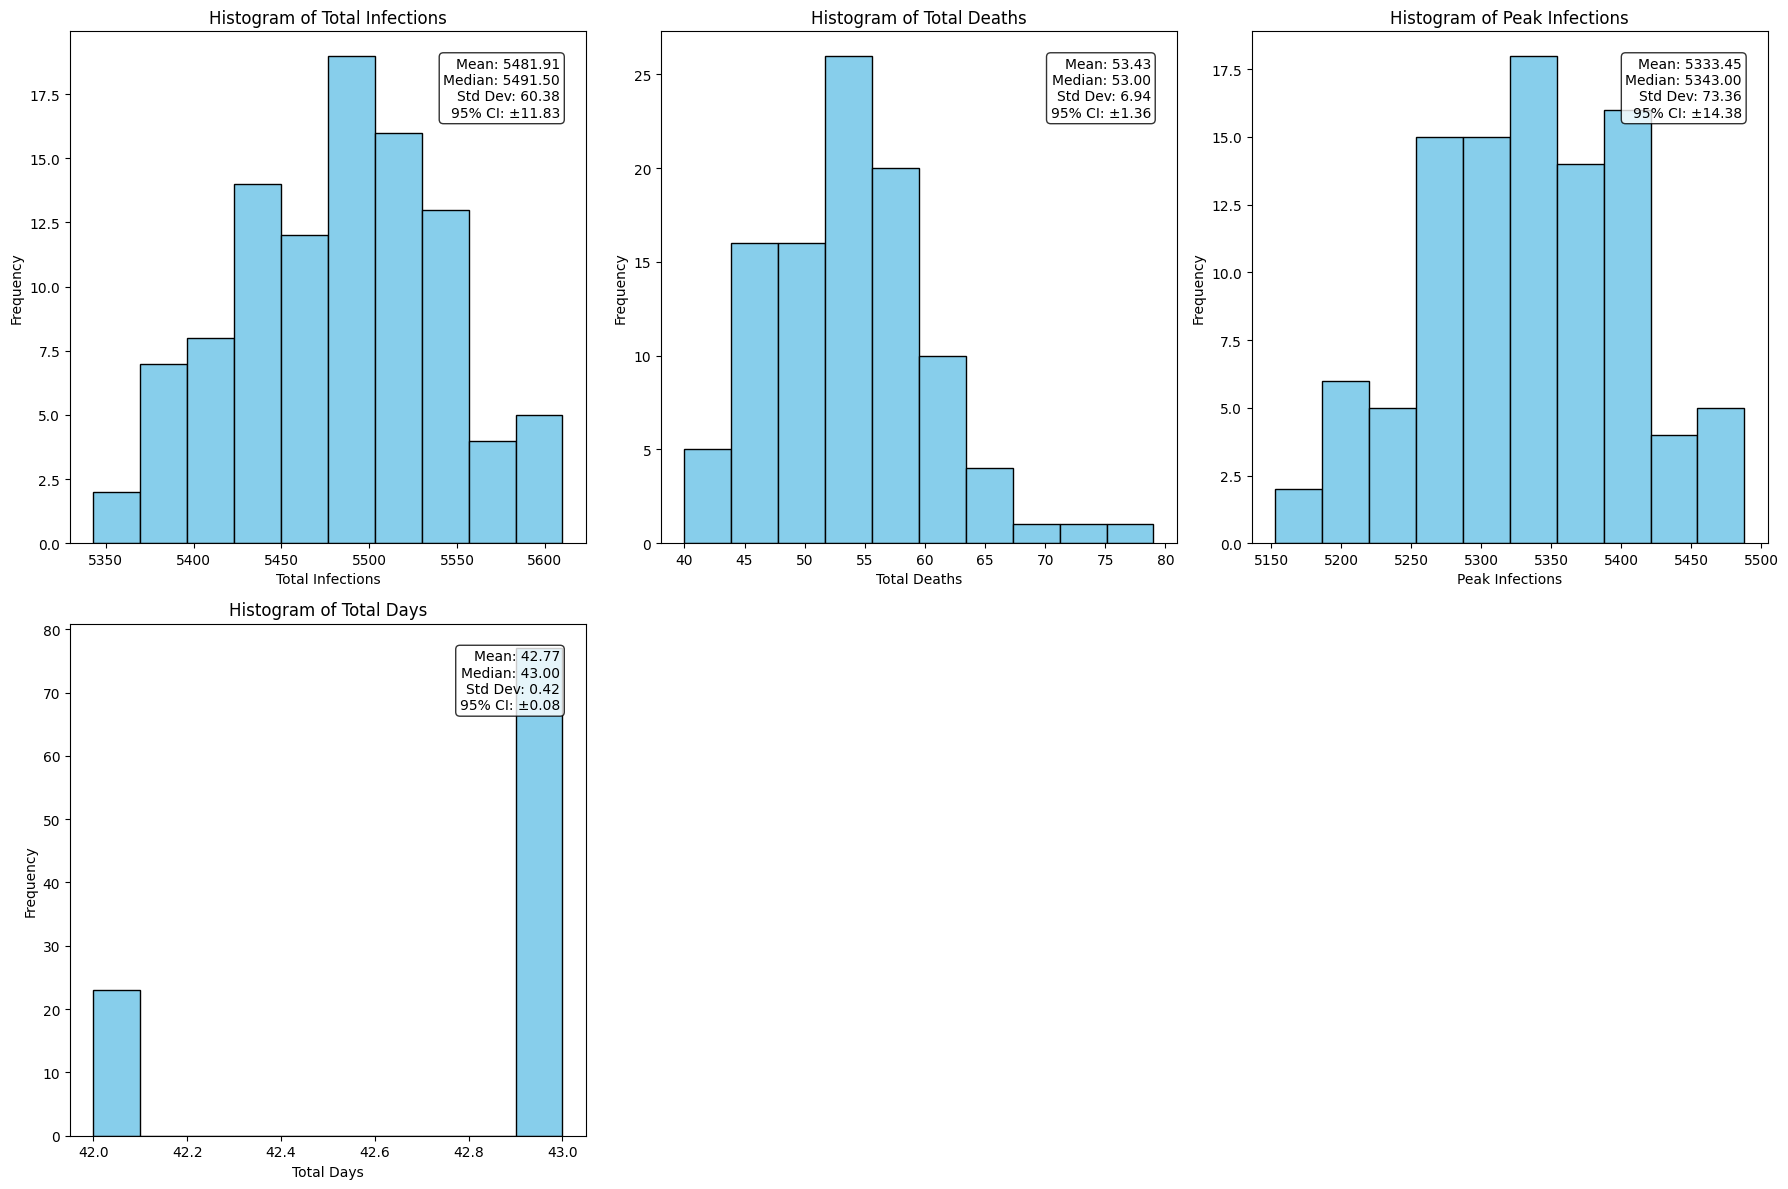

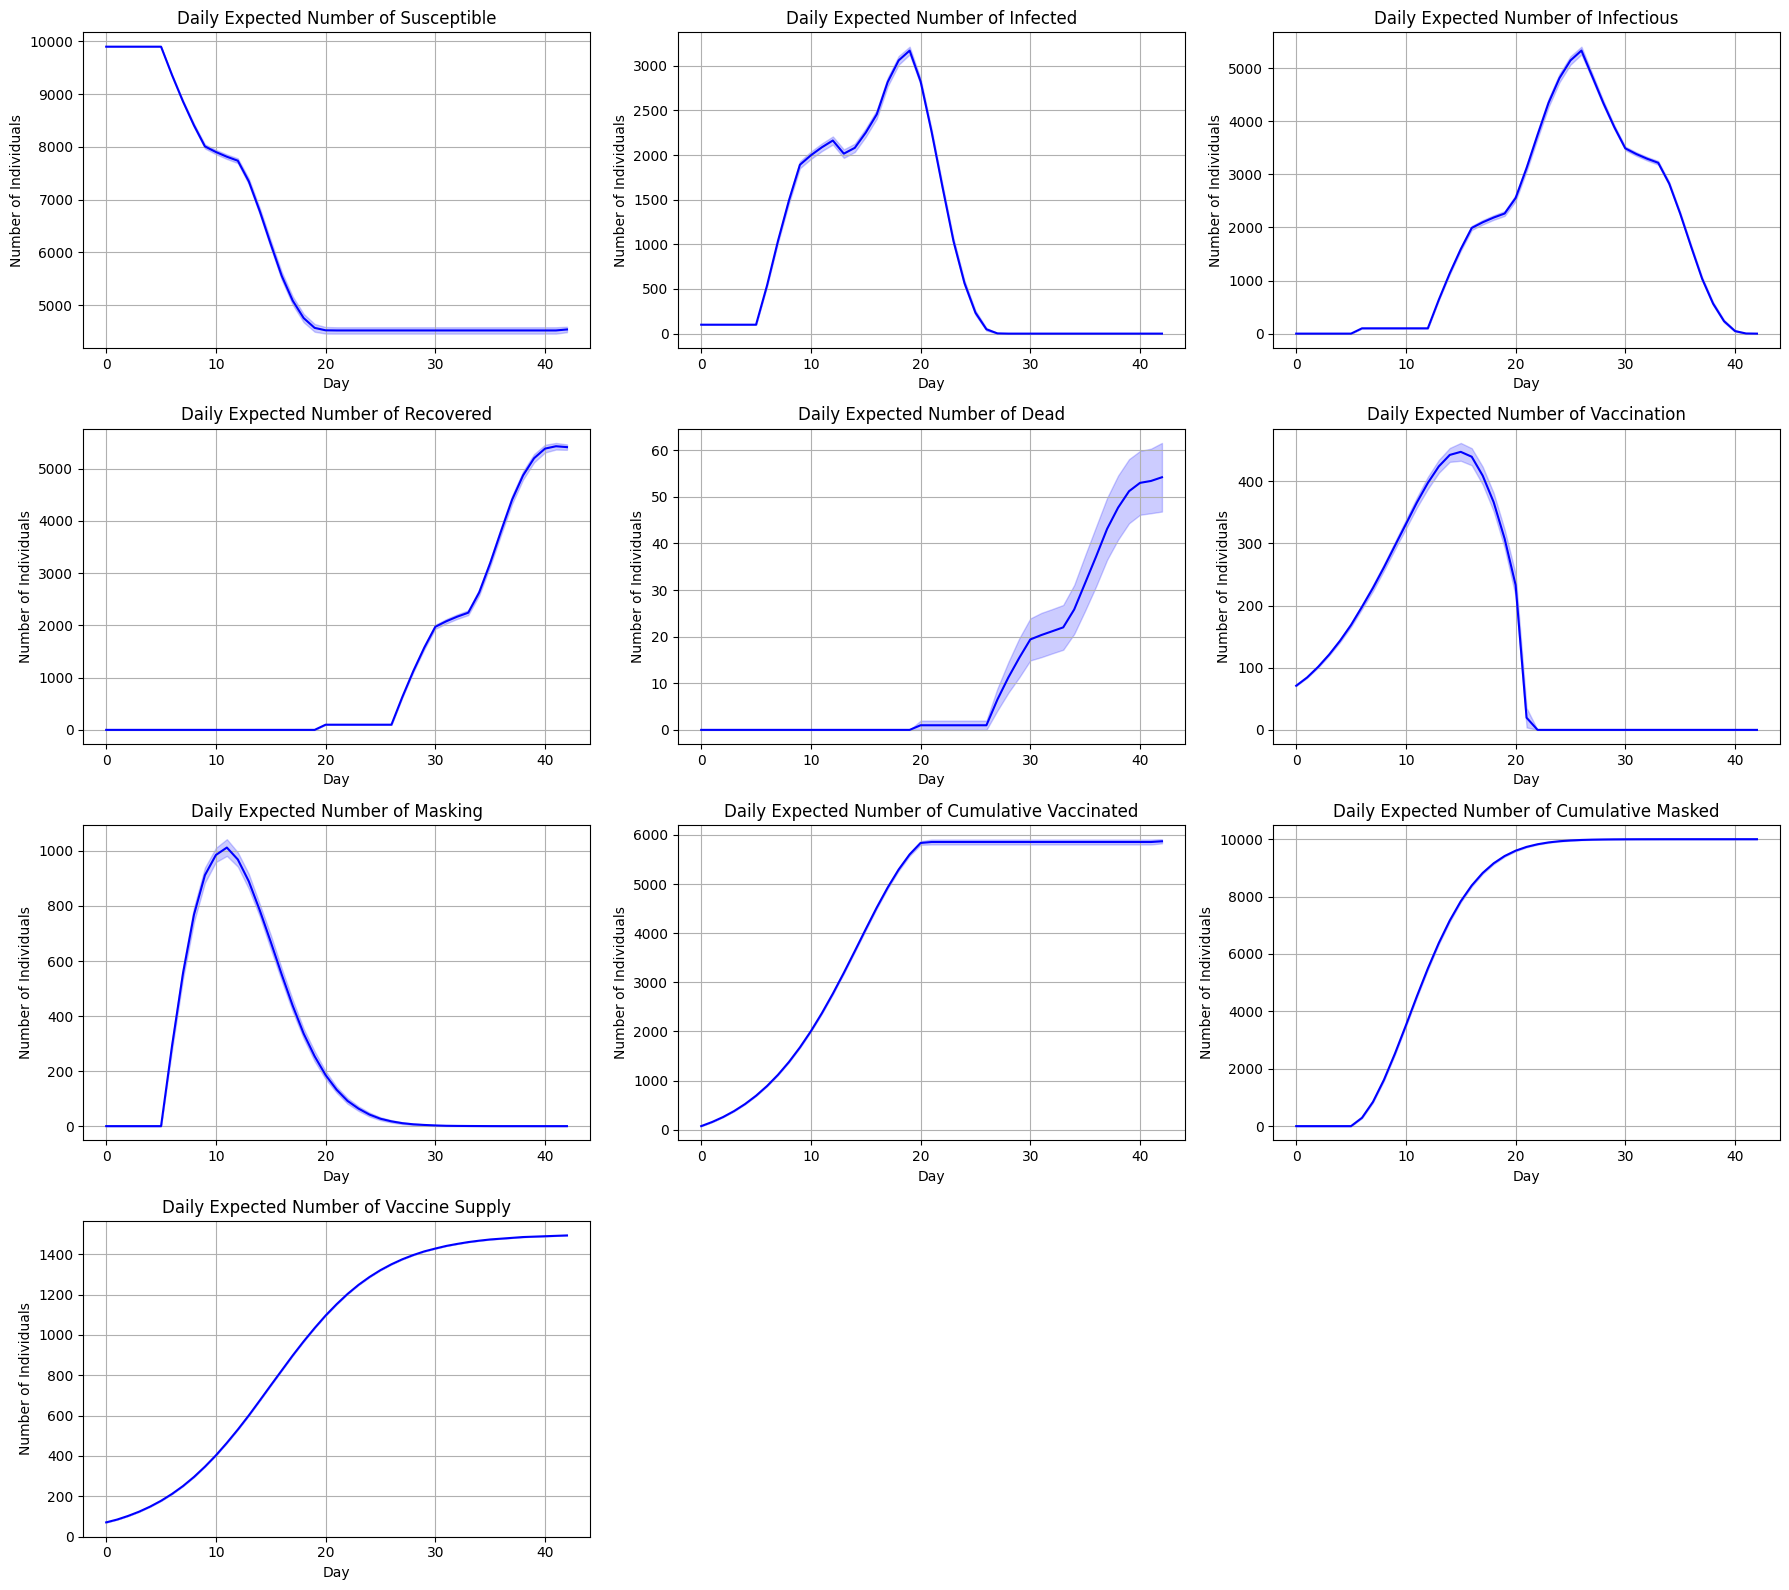

In [ ]:
# Plot histograms with statistical summaries
batch_runner.plot_histograms()

# Plot the expected counts over time
batch_runner.plot_state_over_time()